In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from mpl_toolkits.mplot3d import Axes3D

def clean_dataset(df):
  assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
  df.dropna(inplace=True)
  indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
  return df[indices_to_keep].astype(np.float64)

# Analisis descriptivo

In [2]:
df = pd.read_csv("C:/datos/trainml.csv")
df = clean_dataset(df)
df.TipoDoc.value_counts()

4.0    2171
2.0    2122
1.0    2119
3.0    2088
Name: TipoDoc, dtype: int64

### Del 1 al 4 son tipos de documento de personas naturales. No se tienen datos de empresas. Esta variable será descartada.
1	Cedula
2	Tarjeta de Identidad
3	Cedula de Extranjeria
4	Pasaporte

In [3]:
df.CodActvEconomica.value_counts()

10.0      7965
90.0        41
9001.0       4
4690.0       4
119.0        4
          ... 
2823.0       1
4650.0       1
6619.0       1
7320.0       1
4110.0       1
Name: CodActvEconomica, Length: 330, dtype: int64

In [4]:
df.IdOcupacion.value_counts()

8.0    1088
4.0    1083
6.0    1083
2.0    1073
3.0    1062
1.0    1050
7.0    1040
5.0    1021
Name: IdOcupacion, dtype: int64

In [5]:
df.Patrimonio.value_counts()

4.160746e+09    1
1.185641e+09    1
2.218055e+09    1
3.042252e+09    1
4.742341e+09    1
               ..
4.653255e+09    1
1.901517e+09    1
2.136400e+09    1
1.230433e+09    1
9.249381e+08    1
Name: Patrimonio, Length: 8500, dtype: int64

In [6]:
df.Utilidad.value_counts()

98566143.0     1
296358902.0    1
167926778.0    1
279078894.0    1
185922305.0    1
              ..
209173888.0    1
235197104.0    1
178970142.0    1
274054837.0    1
123884528.0    1
Name: Utilidad, Length: 8500, dtype: int64

### El resto de las variables presenta variedad en sus datos, pueden ser analizadas. Se convertiran CodActvEconomica y IdOcupacion de int a categorica como corresponde, y las variables numericas se llevarán, al menos, a x10^3 para mejorar el rendimiento a la hora del procesamiento. La identificacion de los clientes sera convertida a indice.

In [7]:
df.CodActvEconomica=df.CodActvEconomica.astype("int").astype("str")
df.IdOcupacion =df.IdOcupacion.astype("str")
df.Patrimonio =df.Patrimonio.div(1000) #x10^3 (1K)
df.Utilidad =df.Utilidad.div(1000) #x10^3 (1K)
df.index = df.Identificacion
df = df.loc[:,['CodActvEconomica', 'IdOcupacion', 'Patrimonio', 'Utilidad']]
df.info()
df.describe()
df = df.reset_index()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8500 entries, 29384484.0 to 75180897.0
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CodActvEconomica  8500 non-null   object 
 1   IdOcupacion       8500 non-null   object 
 2   Patrimonio        8500 non-null   float64
 3   Utilidad          8500 non-null   float64
dtypes: float64(2), object(2)
memory usage: 332.0+ KB


# Analisis Exploratorio

## Analisis de CodActvEconomica

In [8]:
list_cod = list(df.CodActvEconomica.unique())

In [9]:
len(list_cod)

330

In [10]:
dfAEc1090 = df[df.CodActvEconomica.isin(['10','90'])]
a = dfAEc1090.groupby(['CodActvEconomica']).agg({'Identificacion':'count'}).reset_index()
a[a.Identificacion>10]

,CodActvEconomica,Identificacion
0,10,7965
1,90,41


### La base con respecto a codigo de actividad esta muy desbalanceada, ya que mas del 93% de los usuarios (8500) pertenecen al codigo 10, mientras el 7 % restante estan distribuidos en  329 restantes.

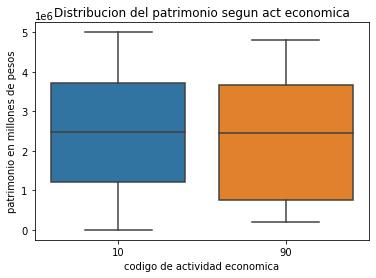

In [11]:
sb.boxplot(y='Patrimonio', x ='CodActvEconomica', data=dfAEc1090)
plt.title('Distribucion del patrimonio segun act economica')
plt.xlabel('codigo de actividad economica')
plt.ylabel('patrimonio en millones de pesos')
plt.show()

In [12]:
##test = df[df.CodActvEconomica == 10]
df.groupby(['IdOcupacion','CodActvEconomica']).agg({'Identificacion':'count'}).reset_index()

,IdOcupacion,CodActvEconomica,Identificacion
0,1.0,10,980
1,1.0,1090,1
2,1.0,1101,1
3,1.0,124,1
4,1.0,1313,1
...,...,...,...
482,8.0,9102,1
483,8.0,9312,1
484,8.0,9420,1
485,8.0,9523,1


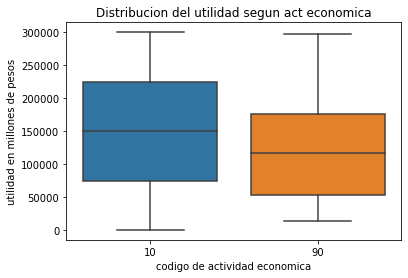

In [13]:
sb.boxplot(y='Utilidad', x ='CodActvEconomica', data=dfAEc1090)
plt.title('Distribucion del utilidad segun act economica')
plt.xlabel('codigo de actividad economica')
plt.ylabel('utilidad en millones de pesos')
plt.show()

### La Act. Ec. muestra una ligera discriminacion frente a la utilidad

## Analisis de IdOcupacion 

In [14]:
list_ocu = list(df.IdOcupacion.unique())
len(list_ocu)

8

In [15]:
dfOcu = df
a = dfOcu.groupby(['IdOcupacion']).agg({'Identificacion':'count'}).reset_index()
a[a.Identificacion>10]


,IdOcupacion,Identificacion
0,1.0,1050
1,2.0,1073
2,3.0,1062
3,4.0,1083
4,5.0,1021
5,6.0,1083
6,7.0,1040
7,8.0,1088


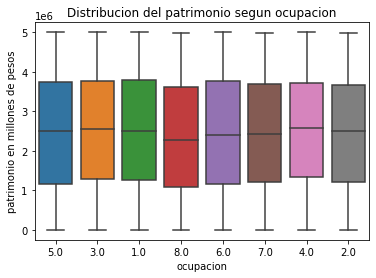

In [16]:
dfOcu = df
sb.boxplot(y='Patrimonio', x ='IdOcupacion', data=dfOcu)
plt.title('Distribucion del patrimonio segun ocupacion')
plt.xlabel('ocupacion')
plt.ylabel('patrimonio en millones de pesos')
plt.show()

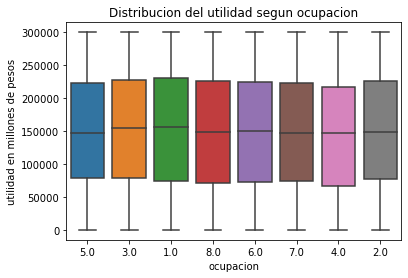

In [17]:
sb.boxplot(y='Utilidad', x ='IdOcupacion', data=dfOcu)
plt.title('Distribucion del utilidad segun ocupacion')
plt.xlabel('ocupacion')
plt.ylabel('utilidad en millones de pesos')
plt.show()

### Las ocupaciones se distribuyen muy similar frente a utilidad y el patrimonio. 

## Analisis de Utilidad y Patrimonio

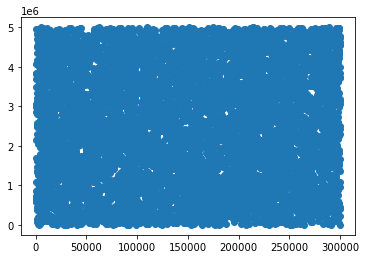

In [18]:
pyplot.scatter(df.Utilidad,df.Patrimonio)
plt.show()

### Utilidad y Patrimonio entre si no muestran discriminacion alguna. Dado que las variables actuales no aportan como para aplicar algoritmos, generamos otras a partir de esta información como la Rentabilidad y una categorizacion de la misma.

In [19]:
rentabilidad = (df.Utilidad/df.Patrimonio) *100
rentabilidad.describe()

count     8500.000000
mean        32.241913
std        502.870331
min          0.003101
25%          2.959021
50%          6.073590
75%         12.260072
max      33164.906012
dtype: float64

In [59]:
def rentabilidad_catego(x):
     if x < 0:
        return 'A'
     elif x>=0 and x<=15:
        return 'B'
     elif x>=16 and x<=30:
        return 'C'
     elif x>=31 and x<=50:
        return 'D'
     elif x>=51 and x<=100:
        return 'F'
     else :
        return 'G'
categoria = rentabilidad.apply(rentabilidad_catego)
df['Rentabilidad'] = rentabilidad
df['Categoria'] = categoria
a = df.groupby(['Categoria']).agg({'Identificacion':'count'}).reset_index()
a[a.Identificacion>0]

,Categoria,Identificacion
0,B,6739
1,C,765
2,D,327
3,F,267
4,G,402


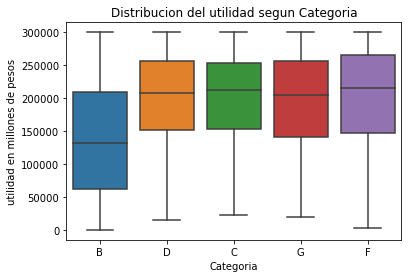

In [21]:
sb.boxplot(y='Utilidad', x ='Categoria', data=df)
plt.title('Distribucion del utilidad segun Categoria')
plt.xlabel('Categoria')
plt.ylabel('utilidad en millones de pesos')
plt.show()

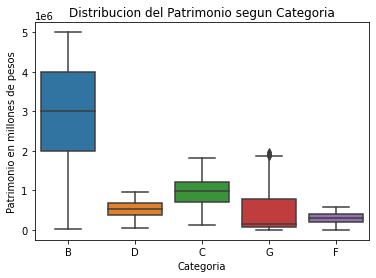

In [22]:
sb.boxplot(y='Patrimonio', x ='Categoria', data=df)
plt.title('Distribucion del Patrimonio segun Categoria')
plt.xlabel('Categoria')
plt.ylabel('Patrimonio en millones de pesos')
plt.show()

#### Al categorizar las variables de rentabilidad nos muestra mayor diferenciacion frente utilidad y patrimonio, generando grupos de personas naturales que con menos patrimonio generan mayor utilidad, y viceversa

# Segmentacion con Arbol de decision

In [23]:
from sklearn.model_selection import train_test_split
x = df[['Utilidad','Patrimonio','CodActvEconomica','IdOcupacion']]
y = df[['Categoria']]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=123)

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import Image as PImage

decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=100,
                                            min_samples_leaf=107,
                                            max_depth = 4) #,class_weight={1:3.5}
tree = decision_tree.fit(x_train, y_train)
#confusion_matrix(y_test, tree.predict(x_test))
from sklearn.metrics import classification_report
print(classification_report(y_test,tree.predict(x_test),labels=list(y.Categoria.unique())))

              precision    recall  f1-score   support

           B       0.97      0.98      0.97      1339
           D       0.26      0.19      0.22        62
           C       0.68      0.73      0.71       166
           G       0.83      0.56      0.67        86
           F       0.52      0.66      0.58        47

    accuracy                           0.90      1700
   macro avg       0.65      0.63      0.63      1700
weighted avg       0.89      0.90      0.89      1700



## Importancia de variables

Feature: 0, Score: 0.20341
Feature: 1, Score: 0.79659
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000


<BarContainer object of 4 artists>

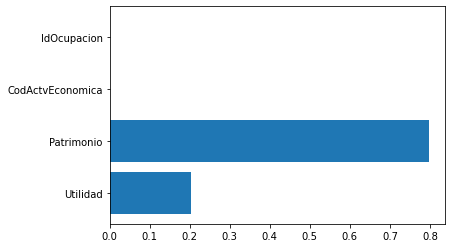

In [25]:
from matplotlib import pyplot
importance = tree.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

plt.barh(x_train.columns, tree.feature_importances_)

### La variable mas importante del modelo es Patrimonio

# Segmentacion usando FAMD y MCA con K-means

In [26]:
x = df[['CodActvEconomica', 'IdOcupacion', 'Patrimonio', 'Utilidad','Categoria']]

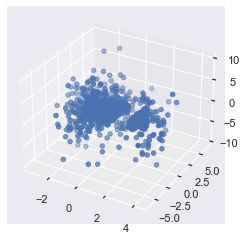

In [28]:
import prince
famd = prince.FAMD(
     n_components=3,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
famd = famd.fit(x)
a = famd.row_coordinates(x)
sb.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(a[0], a[1], a[2])
plt.show()


No handles with labels found to put in legend.


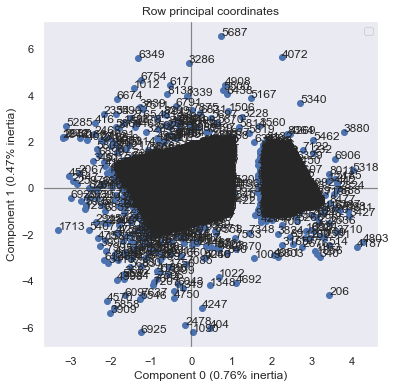

In [29]:
ax = famd.plot_row_coordinates(
     x,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     labels=x.index,
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
 ).get_figure()

In [30]:
famd.eigenvalues_

array([1.72898037e-04, 1.07036936e-04, 7.11723974e-05])

In [31]:
eis=famd.eigenvalues_.sum()

In [32]:
famd.eigenvalues_[0]/eis

0.49243636522548495

In [33]:
famd.eigenvalues_[1]/eis

0.30485528003007295

In [34]:
famd.total_inertia_

0.022782257997630385

In [35]:
famd.explained_inertia_

array([0.00758915, 0.00469826, 0.00312403])

### La inercia es muy baja, por lo que las variables presentan poca asociacion o correlacion. 0,022 < 3 (componentes dimensiones). Realizaremos el analisis con MCA. Antes categorizaremos las variables Patrimonio y Utilidad para poder usarlas.

In [36]:
df.Patrimonio.describe()

count    8.500000e+03
mean     2.480248e+06
std      1.447110e+06
min      3.624670e+02
25%      1.210539e+06
50%      2.478655e+06
75%      3.721851e+06
max      4.999368e+06
Name: Patrimonio, dtype: float64

In [37]:
df.Utilidad.describe()

count      8500.000000
mean     149590.943432
std       86834.603636
min          90.701000
25%       74153.157250
50%      149992.896000
75%      224631.324000
max      299964.299000
Name: Utilidad, dtype: float64

In [60]:
def patrimonio_catego(x):     
     if x>=0 and x<=1000000:
        return 'P1'
     elif x>1000000 and x<=2000000:
        return 'P2'
     elif x>2000000 and x<=3000000:
        return 'P3'
     elif x>3000000 and x<=4000000:
        return 'P4'
     elif x>4000000:
        return 'P5'
     else :
        return 'P0'
CatPat = df.Patrimonio.apply(patrimonio_catego)
df['CPk'] = CatPat
def utilidad_catego(x):     
     if x>=0 and x<=100000:
        return 'U1'
     elif x>100000 and x<=200000:
        return 'U2'
     elif x>200000:
        return 'U3'
     else :
        return 'U0'
CatUti = df.Utilidad.apply(utilidad_catego)
df['CUk'] = CatUti
df

,Identificacion,CodActvEconomica,IdOcupacion,Patrimonio,Utilidad,Categoria,CPk,CUk,Rentabilidad
0,29384484.0,10,5.0,1884736.769,265002.051,B,P2,U3,14.060428
1,79423160.0,10,5.0,1851091.994,143944.466,B,P2,U2,7.776192
2,82244497.0,10,3.0,490653.121,207993.922,D,P1,U3,42.391236
3,78606804.0,10,1.0,938083.495,182264.815,C,P1,U2,19.429487
4,68255584.0,10,8.0,1289214.905,117521.440,B,P2,U2,9.115737
...,...,...,...,...,...,...,...,...,...
8495,70607291.0,10,6.0,3850163.203,3741.627,B,P4,U1,0.097181
8496,6493680.0,10,7.0,540538.365,203304.362,D,P1,U3,37.611458
8497,96444510.0,10,8.0,2804326.820,28469.675,B,P3,U1,1.015205
8498,80578724.0,10,7.0,3062004.016,256682.278,B,P4,U3,8.382820


In [39]:
a = df.groupby(['CUk']).agg({'Identificacion':'count'}).reset_index()
a[a.Identificacion>10]

,CUk,Identificacion
0,U1,2847
1,U2,2804
2,U3,2849


In [40]:
a = df.groupby(['CPk']).agg({'Identificacion':'count'}).reset_index()
a[a.Identificacion>10]

,CPk,Identificacion
0,P1,1760
1,P2,1689
2,P3,1682
3,P4,1697
4,P5,1672


In [41]:
dfMCA = df.loc[:,['CodActvEconomica', 'IdOcupacion', 'CPk', 'CUk', 'Categoria']]
dfMCA
### 1. categorizar las variables
### 2. correr el MCA Y  mirar la inercia explicada
### 3. tomar los 3 componenre y  correr un kmeans con esos 3 factores

,CodActvEconomica,IdOcupacion,CPk,CUk,Categoria
0,10,5.0,P2,U3,B
1,10,5.0,P2,U2,B
2,10,3.0,P1,U3,D
3,10,1.0,P1,U2,C
4,10,8.0,P2,U2,B
...,...,...,...,...,...
8495,10,6.0,P4,U1,B
8496,10,7.0,P1,U3,D
8497,10,8.0,P3,U1,B
8498,10,7.0,P4,U3,B


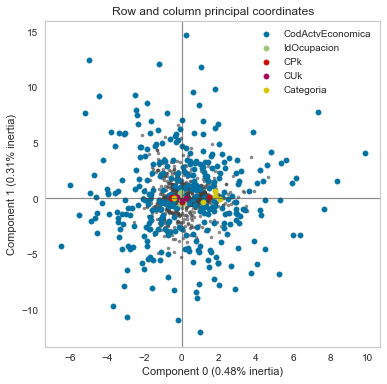

In [78]:
mca = prince.MCA(
     n_components=3,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
 )
mca = mca.fit(dfMCA)
ax = mca.plot_coordinates(
     X=dfMCA,
     ax=None,
     figsize=(6, 6),
     show_row_points=True,
     row_points_size=10,
     show_row_labels=False,
     show_column_points=True,
     column_points_size=30,
     show_column_labels=False,
     legend_n_cols=1
 ).get_figure()

In [79]:
mca.eigenvalues_

[0.33458459691001435, 0.2137331500011759, 0.21053302651683992]

In [80]:
mca.total_inertia_

69.2

In [81]:
componentes = mca.explained_inertia_
componentes

[0.004835037527601363, 0.0030886293352771084, 0.003042384776254912]

In [82]:
mca = mca.transform(dfMCA)
mca

,0,1,2
0,-0.048503,-0.111423,0.002998
1,-0.126614,-0.178995,0.191309
2,1.289269,0.268115,-0.356908
3,0.926945,-0.215970,0.087585
4,-0.089316,-0.219408,0.109178
...,...,...,...
8495,-0.440458,0.051613,-0.087019
8496,1.280703,-0.189546,-0.105923
8497,-0.386251,0.058539,0.013046
8498,-0.285525,-0.216444,-0.196258


In [86]:
##dfK = df.loc[:,['Patrimonio', 'Utilidad', 'Rentabilidad']]
dfK = mca
dfK

,0,1,2
0,-0.048503,-0.111423,0.002998
1,-0.126614,-0.178995,0.191309
2,1.289269,0.268115,-0.356908
3,0.926945,-0.215970,0.087585
4,-0.089316,-0.219408,0.109178
...,...,...,...
8495,-0.440458,0.051613,-0.087019
8496,1.280703,-0.189546,-0.105923
8497,-0.386251,0.058539,0.013046
8498,-0.285525,-0.216444,-0.196258


In [87]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
for i in range(2,8):
  '''
  Create KMeans instance for different number of clusters
  '''
  km = KMeans(n_clusters=i,max_iter=5, random_state=42).fit(dfK)
  score = silhouette_score(dfK, km.labels_, metric='euclidean')

# Print the score
  print('Silhouetter Score: %.3f' % i ,score)

Silhouetter Score: 2.000 0.5849993363480105
Silhouetter Score: 3.000 0.6017207512702392
Silhouetter Score: 4.000 0.6125784767852029
Silhouetter Score: 5.000 0.6208305941488034
Silhouetter Score: 6.000 0.4998295113716048
Silhouetter Score: 7.000 0.43531021013574656


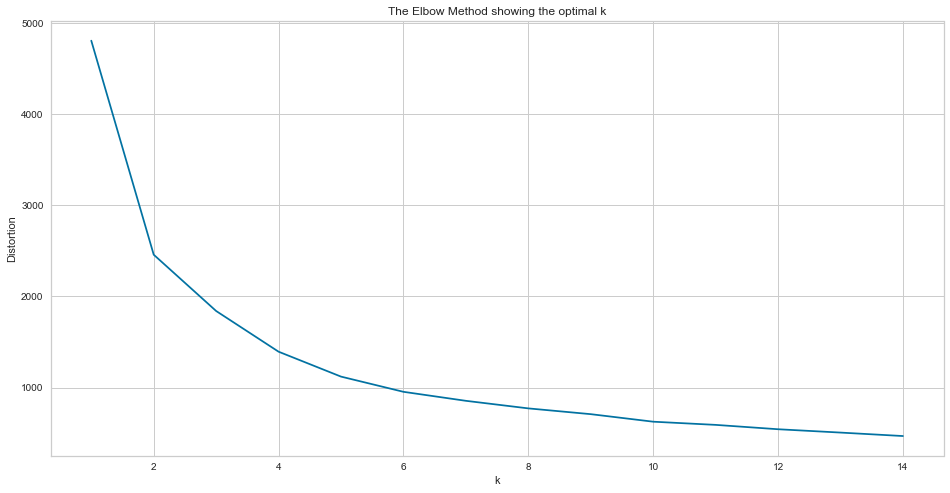

In [88]:
## Metodologia Elbow
distortions = []
K = range(1,15)
for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(dfK.iloc[:,[0,1]])
  distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

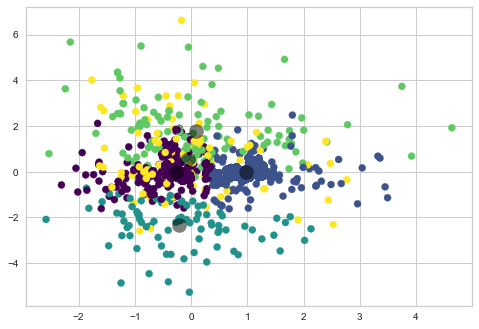

In [89]:
f1 = dfK.iloc[:,0].values
f2 = dfK.iloc[:,1].values
kmeans = KMeans(n_clusters=5).fit(dfK)
y_kmeans = kmeans.predict(dfK)
centroids = kmeans.cluster_centers_
plt.scatter(f1, f2, c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [92]:
score = silhouette_score(dfK, kmeans.labels_, metric='euclidean')
score

0.6206298810316795

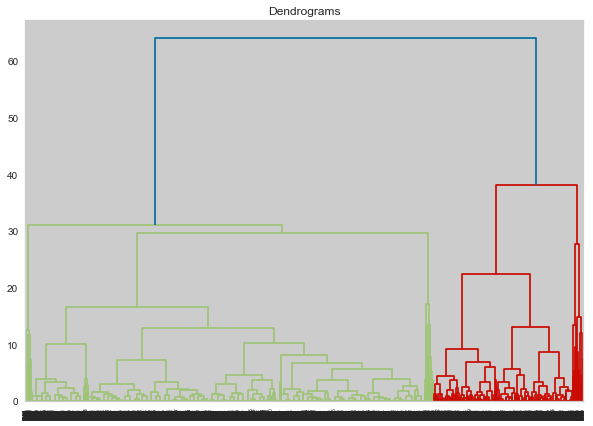

In [93]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(dfK, method='ward'))

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit_predict(dfK)